Michael Stafford, Tyler Sanders, Andrew Cherpeski, Alex Melo, and Samuel McIntyre

### **Introduction**

While the success of a high school is typically measured by graduation rate and standardized test scores, the reality of a typical student’s education may be influenced by a multitude of factors including economic factors, class sizes, teacher pay, and more. Our project examines two separate metrics for school success: the average ACT score and the graduation rate for a given school. We investigated what factors are most highly associated with school success in order to suggest future causality research about those highly correlated factors. Ultimately, we hope schools will be able to use this data in order to better serve the educational needs of their students.\
Our primary source of data was the Utah State Board of Education (USBE)  [1], which publishes yearly district- and school-level data. In particular, we used the datasets that track ACT scores, graduation rates, median class sizes, enrollment demographic data, and graduation rates. Our data focuses on the 2021 and 2022 school years, as this is the most recent ACT score data available. We used exclusively school-level data for our project and focused only on schools with 11th- and 12th-grade students.

In [29]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import warnings
warnings.simplefilter('ignore')

### **Data Cleaning and Feature Engineering**
In the data cleaning phase, various techniques were applied to enhance the dataset's integrity. The data cleaning process involved addressing missing values through imputation, where the overall average for each specific school served as a reliable substitute. Non-numeric data were one-hot encoded, transforming categorical variables into a suitable format for analysis. Irrelevant columns, such as school names, were removed to streamline the dataset and optimize model efficiency. We paid close attention to keeping only the information related to the specific grades we were interested in. This way, we made sure the dataset exactly matched what we needed for our study.

In [30]:
#Read in data
attendance_22 = pd.read_excel('Data/2022Attendance.xlsx',sheet_name='By School')
school_names = pd.read_excel("Data/School Names and ID.xlsx")
attendance_22 = attendance_22[attendance_22['Measure'] == 'Attendance Rate']
#rename columns, drop irrelevant columns
attendance_22 = attendance_22.rename(columns={'School_Name':'School Name','school_id':'School ID'})
attendance_22 = attendance_22.drop(columns=['LEA Type','Measure','School Year','LEA_name','district_id','district_nbr','school_number'])
col_names = attendance_22.columns
col_names = [col_names[0]] + [col_names[-1]] + list(col_names[1:-1])
attendance_22 = attendance_22[col_names]
#rename Utah Arts Academy OLD to Utah Arts Academy in the 2022 data
attendance_22.loc[attendance_22['School Name']=='Utah Arts Academy OLD','School Name'] = 'Utah Arts Academy'
attendance_22_short = attendance_22.copy()
attendance_22_short.drop(attendance_22_short.filter(regex='Grade [1-8]$').columns, axis=1,inplace=True)
attendance_22_short.drop(columns=['Kindergarten'],inplace=True)
attendance_22_short.dropna(subset=['Grade 12'],inplace=True)
#Fill any missing attendance data with the "overall" attendance data
for col in attendance_22_short.columns[7:]:
    attendance_22_short[col] = attendance_22_short[col].fillna(attendance_22_short['K-12 Overall'])
#Rename columns
attendance_22_short.rename(columns={'K-12 Overall':'Overall'},inplace=True)
columns_rename = dict()
for col in attendance_22_short.columns[2:]:
    columns_rename[col] = f'{col} Attendance 2022'
attendance_22_short.rename(columns=columns_rename,inplace=True)
#Add a AVG minority attendance column:
minorities = list(attendance_22_short.columns[7:])
minorities.remove('White Attendance 2022');minorities.remove('Female Attendance 2022');minorities.remove('Male Attendance 2022')
attendance_22_short['Avg Minority Attendance 2022'] = attendance_22_short[minorities].sum(axis=1)/len(minorities)

### **Analysis**

Since ACT is a standardized test and standards for graduation rates vary across schools, we performed the majority of our regression treating ACT scores as the dependent variable corresponding to school success. We performed a regression treating the 2021 ACT data as an independent variable and the 2022 data as a dependent variable and found that the coefficient value was 0.89 even with no other control variables (besides a constant). If we weight by the number of juniors and seniors at the school then the coefficient increases to 0.999 - so the schools with the most consistent scores are the larger ones, which is what we would expect. This means that the prior year's average ACT score is an excellent predictor of how a school will perform this year. Because of this, we concluded that average ACT scores are mostly independent of what specific students are taking the test, and highly dependent on the school the students go to. Furthermore, we concluded that using the 2022 ACT data alone as the dependent variable was a valid measure of school success. Visual representations below show that the spread of ACT scores in the sample is significant and somewhat bell shaped, as well as the persistence of ACT scores from year to year. 

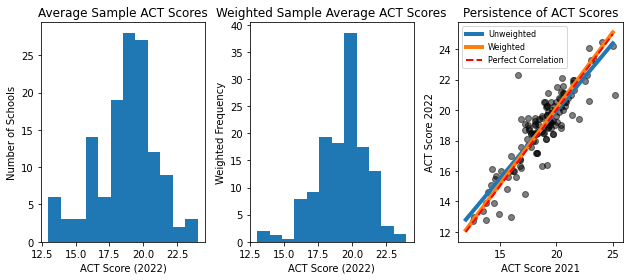

In [31]:
#Make a histogram of ACT scores,Weight by School Size
data = pd.read_csv('cleaned_with_salaries.csv')
weights = data['students_11_12'] / data['students_11_12'].mean()
act22 = np.round(data['act22'])
fig, [ax, ax2, ax3] = plt.subplots(figsize=(9,4), nrows=1, ncols=3)
act22.plot(kind='hist', bins=12, grid=False, ax=ax)
act22.plot(kind="hist", weights=weights, ax = ax2, bins=12)
ax.set_title("Average Sample ACT Scores")
ax.set_xlabel("ACT Score (2022)")
ax.set_ylabel("Number of Schools")
ax2.set_title("Weighted Sample Average ACT Scores")
ax2.set_xlabel("ACT Score (2022)")
ax2.set_ylabel("Weighted Frequency")
plt.tight_layout()
#Regression of past year ACT on this year ACT
X = data['act21'].values.reshape(-1,1)
y = data['act22'].values.reshape(-1,1)
act_reg_model = LinearRegression().fit(X, y) #Unweighted Model
beta, intercept = act_reg_model.coef_, act_reg_model.intercept_
act_reg_model.fit(X, y, weights) #Weighted Model
beta2, intercept2 = act_reg_model.coef_, act_reg_model.intercept_
domain = np.linspace(12, 25, 100)
ax3.scatter(data['act21'], data['act22'], color='black', marker='o', alpha=0.5) #Persistence Graph
ax3.plot(domain, intercept[0]+beta[0]*domain, lw=4, label='Unweighted')
ax3.plot(domain, intercept2[0]+beta2[0]*domain, lw=4, label='Weighted')
ax3.plot(domain, domain, '--', lw=2, label='Perfect Correlation', color='red')
ax3.set_xlabel("ACT Score 2021")
ax3.set_ylabel("ACT Score 2022")
ax3.set_title("Persistence of ACT Scores")
ax3.legend(fontsize=8)
plt.show()

In all models we weighted by the student population in order to prioritize larger schools since they had more students that took the test. Moreover, they are of greater interest since they represent the majority of students. This also helps to produce more reasonable results, since the smallest schools tend to have unusually high or low ACT scores since many of them are more specialized in nature. Our first pass at the data involved using OLS and manually evaluating which features seemed to be important as well as how predictive our data was. The results are below.

In [32]:
#Regression with many different features
y = data['act22'].values
X = data[['meanschooladministratorsalaryind','administratortoteachermeansalary', 'meanteachersalaryindollars',
       'log_students', 'attendance21','attendance22', 'americanindian_2022_p','afamblack_2022_p', 'asian_2022_p', 
          'hispanic_2022_p', 'multiplerace_2022_p', 'pacificislander_2022_p', 'totalk12_2022', 'grade_9_2022', 
        'grade_10_2022', 'grade_11_2022', 'grade_12_2022', 'female_2022_p','economicallydisadvantaged_2022_p', 
          'englishlearner_2022_p', 'studentwithadisability_2022_p','homeless_2022_p', 'charter']]
X = X.fillna(0)
X = sm.add_constant(X)
model = sm.OLS(y, X).fit(weights=weights)
#print(model.summary(slim=True))
print("MSE:", mean_squared_error(model.predict(X), y), "AIC:", model.aic, "BIC:", model.bic, "R2", model.rsquared)

MSE: 1.3587168642043839 AIC: 463.0631546945619 BIC: 532.2504008366348 R2 0.7702893171776047


The above regression suggests that many of the variables we have are not very relevant in predicting a school's average ACT score. Although none of the columns are strictly collinear, including all of these variables does introduce a number of columns that are nearly multicollinear (such as attendance in 2021 and 2022), which undoubtadly overfits the model and produces bad estimates for beta. The following variables seem as if they are not aiding in our predictions: teacher salaries, log number of students, detailed breakdown of school size, percent female (Based on p values, not shown, but available by uncommenting print model summary). If we remove those variables we get the model in the next panel. 

In [33]:
#Regression with further reduced data
y = data['act22'].values
X = data[['americanindian_2022_p',
       'afamblack_2022_p', 'asian_2022_p', 'hispanic_2022_p', 'multiplerace_2022_p', 'pacificislander_2022_p',
          'totalk12_2022', 'economicallydisadvantaged_2022_p', 'englishlearner_2022_p', 
          'studentwithadisability_2022_p','homeless_2022_p', 'charter']]
X = X.fillna(0)
X = sm.add_constant(X)
model = sm.OLS(y, X).fit(weights=weights)
#print(model.summary(slim=True))
print("MSE:", mean_squared_error(model.predict(X), y), "AIC:", model.aic, "BIC:", model.bic, "R2", model.rsquared)

MSE: 1.5467341284974283 AIC: 458.17100439803494 BIC: 495.64742939165774 R2 0.7385022868543709


This model has nearly the same R Squared value as the previous one, and improved AIC and BIC scores. Almost all of the features appear to be statistically significant, with the exception of pacificislander proportion, total number of students, and possibly proportion economically disadvantaged. Essentially what this indicates is that, given the available data, predictions made just on the racial proportions of a school seem to predict the average ACT score perform just as well as regressions that include more features. To test that, we include a regression using only the racial breakdown in the next panel. 

In [34]:
#Regression with Racial Breakdown
y = data['act22'].values
X = data[['americanindian_2022_p','afamblack_2022_p', 'asian_2022_p', 'hispanic_2022_p', 'multiplerace_2022_p', 'pacificislander_2022_p']]
X = X.fillna(0)
X = sm.add_constant(X)
model = sm.OLS(y, X).fit(weights=weights)
#print(model.summary(slim=True))
print("MSE:", mean_squared_error(model.predict(X), y), "AIC:", model.aic, "BIC:", model.bic, "R2", model.rsquared)

MSE: 3.089761168604463 AIC: 537.5081538655859 BIC: 557.6877673236904 R2 0.4776313104688975


However, in this model we see a sharp drop in R Squared and a substantial rise in AIC, BIC, and MSE - so clearly some of the other features were actually important in making predictions, and forcasting ACT scores just based on racial demographics is a mistake. In subsequent sections we will explore other approaches such as Ridge and Lasso to identify a good model for the data. \
This was reinforced by Lasso Regularization. We performed Lasso regularization with a hyperparameter gridsearch in order to determine feature importance. The features that were kept mainly related to minority demographic data, but also included student population and whether or not it was a charter school. This feature selection process highlights the power of demographic data in predicting ACT scores and reinforces our prior analysis.

In [35]:
#Read in Dataset, drop appropriate columns
full_dataset = pd.read_csv('cleaned_with_salaries.csv')
full_dataset = full_dataset.fillna(0)
schoolnames = full_dataset['school']
columns = full_dataset.columns
to_drop = ['leaname','school', 'leatype','act21', 'act22', 'english21',
       'english22', 'math21', 'math22', 'reading21', 'reading22', 'science21','grade_9_2022','grade_10_2022','grade_11_2022', 'grade_12_2022',
       'science22', 'students_11_12','gradrate','cohortyear','schoolid_y','totalk12_2022','female_2022_p','white_2022_p','district','attendance_2022_minority_p']
X = full_dataset.drop(columns=to_drop)
y = full_dataset['act22']
#Do L1 regularization with sklearn
reg_lasso = LassoCV(alphas=np.logspace(-4, 20, 100),max_iter=100000)
reg_lasso.fit(X, y,sample_weight=full_dataset['students_11_12']) # Fit the model
lasso_pred = reg_lasso.predict(X) # Best parameter values
MSE_lasso = mean_squared_error(y,lasso_pred)
R2_lasso = r2_score(y,lasso_pred)
params = reg_lasso.coef_
params[np.abs(params) <1e-2] = 0
zero_index = params==0
not_selected_features_lasso = np.array(X.columns)[zero_index]
selected_features_lasso = np.array(X.columns)[~zero_index]
#Print the selected and not selected features
selected_features_lasso_str = ', '.join(map(str, selected_features_lasso))
not_selected_features_lasso_str = ', '.join(map(str, not_selected_features_lasso))
print(f'''
Selected features Lasso:\n{selected_features_lasso_str}
Unselected features Lasso:\n{not_selected_features_lasso_str}
Best MSE Lasso: {MSE_lasso}
Best R2 Lasso: {R2_lasso}
''')


Selected features Lasso:
log_students, attendance21, attendance22, afamblack_2022_p, asian_2022_p, hispanic_2022_p, economicallydisadvantaged_2022_p, englishlearner_2022_p, studentwithadisability_2022_p, charter
Unselected features Lasso:
meanschooladministratorsalaryind, administratortoteachermeansalary, meanteachersalaryindollars, americanindian_2022_p, multiplerace_2022_p, pacificislander_2022_p, male_2022_p, homeless_2022_p
Best MSE Lasso: 2.3745828138971388
Best R2 Lasso: 0.5985425264313309



In the Ridge Regression model below, we see that this model has a fairly high $R^2$ value at .71. It also has a lower MSE than the Lasso, indicating that this model has some predictive advantages over the R1 regularization term.

In [36]:
#Read in Dataset, drop appropriate columns
full_dataset = pd.read_csv('cleaned_with_salaries.csv')
full_dataset = full_dataset.dropna(axis=0)
schoolnames = full_dataset['school']
columns = full_dataset.columns
to_drop = ['leaname','school', 'leatype','act21', 'act22', 'english21',
       'english22', 'math21', 'math22', 'reading21', 'reading22', 'science21','grade_9_2022','grade_10_2022','grade_11_2022', 'grade_12_2022',
       'science22', 'students_11_12','gradrate','cohortyear','schoolid_y','totalk12_2022','female_2022_p','white_2022_p','district','attendance_2022_minority_p']
X = full_dataset.drop(columns=to_drop)
y = full_dataset['act22']
#Do L1 regularization with sklearn
reg_ridge = RidgeCV(alphas=np.logspace(-4, 3, 15))
reg_ridge.fit(X, y,sample_weight=full_dataset['students_11_12']) # Fit the model
ridge_pred = reg_ridge.predict(X) # Best parameter values
MSE_ridge = mean_squared_error(y,ridge_pred)
R2_ridge = r2_score(y,ridge_pred)
params = reg_ridge.coef_
zero_index = params==0

print(f"Best MSE Ridge: {MSE_ridge}")
print(f"Best R2 Ridge: {R2_ridge}")

Best MSE Ridge: 1.6677649201382214
Best R2 Ridge: 0.7120450179150045


### Graduation Rates

Our final analysis studies a school's graduation rate as the target variable. Graduation rates are expressed as a percentage, so each $y_i \in [0,1]$. As such, a logistic regression would be more appropriate to model the data. In order to do this, we split our target data around the average high school graduation rate in Utah [https://www.schools.utah.gov/file/f40bd425-7583-4b56-8835-473a97b75326#:~:text=Graduation%20Rate%20Highlights,-%E2%80%A2&text=Utah's%20state%20graduation%20rate%20for%20the%202022%20cohort%20is%2088.2%25.&text=Five%20of%20the%20nine%20reported,their%20graduation%20rate%20from%202021.&text=A%20total%20of%2045432%20students%20graduated%20from%20Utah's%20high%20schools.&text=Utah's%20graduation%20rate%20has%20increased,2021%20to%2088.2%25%20in%202022.], which is 0.882. Therefore, our target variable is 

$$ \tilde{y_i} = 
\begin{cases} 
    1 & y_i \geq 0.882 \\
    0 & y_i < 0.882 
\end{cases}
$$

Any $\tilde{y_i} = 1$ corresponds to a high school with an above-average graduation rate, while a $\tilde{y_i} = 0$ corresponds to a below-average graduation rate.

We use the following features for our model: mean school administrator salary indicator, administrator to teacher mean salary, an indicator for whether the school is a charter school, the attendance rates for all students, the male attendance rate, the attendance rate of minority students, the attendance rate of economically disadvantaged students, and the logarithm of the total number of students in the school. As before, our model was weighted by student population. Additionally, we included a regularization term. Our results are as follows:

In [37]:
# Additional data cleaning
X = pd.read_csv("cleaned_with_salaries.csv")
X = X[['meanschooladministratorsalaryind', 'administratortoteachermeansalary', 
       'students_11_12', 'gradrate', 'charter', 'attendance22', 'male_2022_p', 
       'attendance_2022_minority_p', 'economicallydisadvantaged_2022_p', 'log_students',]]
# Some attendance values are null. These will be dropped
X = X.dropna()
y_rate = X['gradrate'].copy()
# Define average graduation rates
UTAH_GRAD_RATE = .882
y = y_rate > UTAH_GRAD_RATE
# Remove the graduation rate column from X
del X['gradrate']
# Define the sample weights based on the number of students, remove population col
weights = X['students_11_12'] / X['students_11_12'].sum()
del X['students_11_12']
# Run the optimal regression and display results
log_reg = sm.Logit(y, sm.add_constant(X)).fit_regularized(disp=False, weights=weights)
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               gradrate   No. Observations:                  129
Model:                          Logit   Df Residuals:                      120
Method:                           MLE   Df Model:                            8
Date:                Tue, 05 Dec 2023   Pseudo R-squ.:                  0.2201
Time:                        18:44:04   Log-Likelihood:                -68.855
converged:                       True   LL-Null:                       -88.293
Covariance Type:            nonrobust   LLR p-value:                 5.186e-06
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                              -20.6020      7.238     -2.846      0.004     -34.788      -6.416
meanschooladministratorsalaryind -7.007e-06   1.31e-05     -0.537      0.591   -3.26e-05    1.86e-05
administratortoteachermeansalary    -0.5816      0.558     -1.042      0.297      -1.675       0.512
charter                             -0.9840      0.637     -1.545      0.122      -2.232       0.264
attendance22                        25.8759      7.589      3.410      0.001      11.002      40.750
male_2022_p                         -2.4351      3.727     -0.653      0.514      -9.741       4.871
attendance_2022_minority_p          -1.2526      1.310     -0.956      0.339      -3.820       1.315
economicallydisadvantaged_2022_p    -1.0507      1.260     -0.834      0.404      -3.521       1.419
log_students                         0.1684      0.220      0.765      0.444      -0.263       0.600
====================================================================================================
"""

The above table summarizes our findings. The only variables considered to be statistically significant are the intercept and the attendance variable. All other varaibles have a p-value of at least 0.1. Male attendance, minority attendance, and economically disadvantaged attendance are negatively correlated with graduation rates, but these coefficients are statistically insignificant. More research would be needed to determine whether these variables are truly negatively correlated.

It seems very intuitive that attendance is strongly correlated with graduation rates. After all, students who do not graduate high school generally don't attend frequently. Additionally, in Utah (and most other states), high school graduation requirements are such that simply attending goes a long way in helping a student graduate.

To further analyze the correlation between attendance and graduation rates, we ran a simple logistic regression with attendance as the only feature. A summary and graph is included below: 

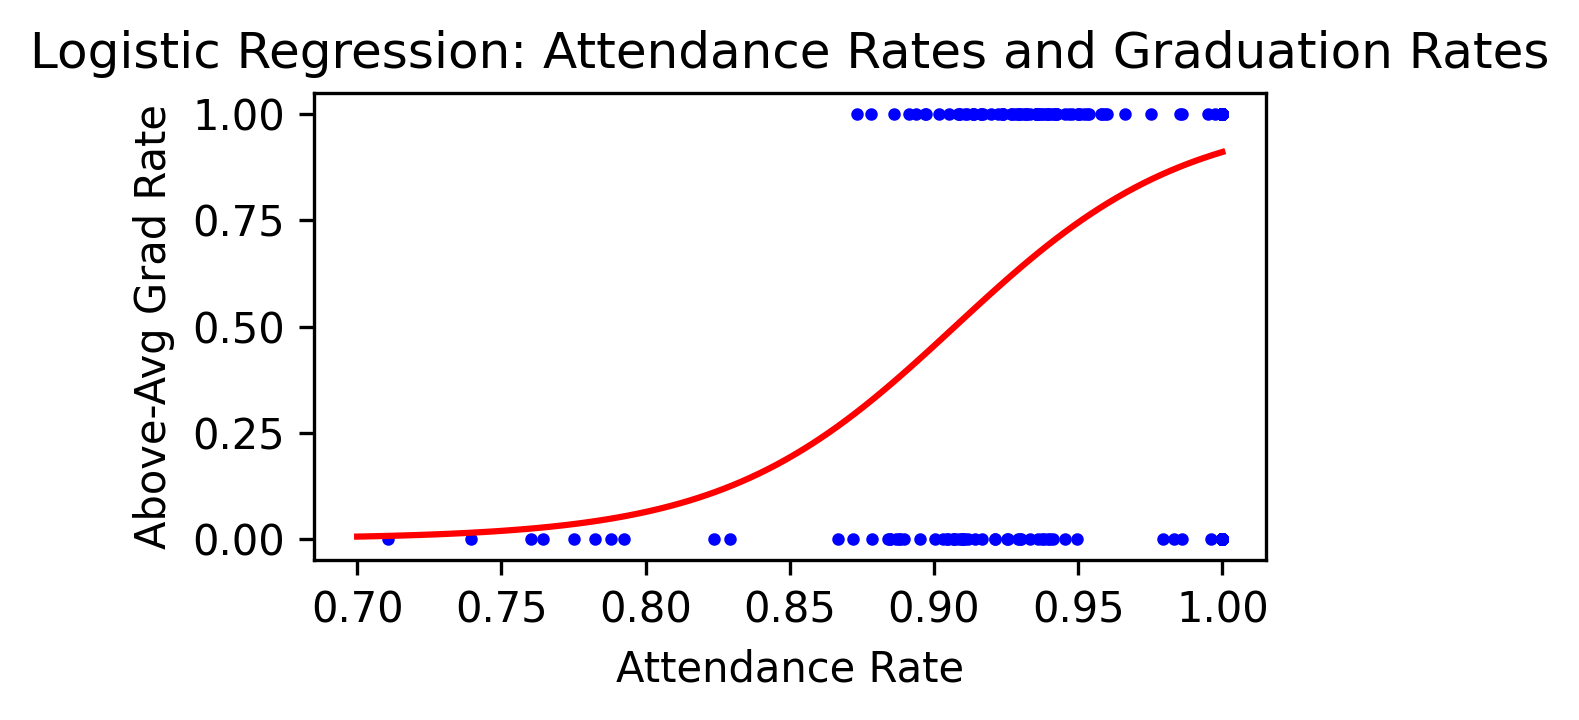

In [43]:
plt.figure(figsize=(4,2.5),dpi=300)
attendance = X[['attendance22']]
attendance = sm.add_constant(attendance)
attend_model = sm.Logit(y, attendance).fit_regularized(disp=False, weights=weights)
plt.plot(attendance, y, 'bo', markersize=2)
domain = np.linspace(0.7,1,100)
beta = attend_model.params.values
model = np.vectorize(lambda x: (1 + np.exp(-1*(beta[0] + x*beta[1])))**-1)
plt.plot(domain, model(domain), 'r-')
plt.title("Logistic Regression: Attendance Rates and Graduation Rates")
plt.xlabel("Attendance Rate")
plt.ylabel("Above-Avg Grad Rate")
plt.tight_layout()
plt.show()

Again, there is a clear positive correlation between the attendance rate and whether a high school has an above-average graduation rate.

### Conclusion
Our dataset was fairly limited. We only analyzed Utah high schools, but a future analysis would include similar data at a national level. Furthermore, more specific county level data from the US census could be used to address some of the complexities of demographic data. Despite limited data, we successfully identified an area of future research for exploring success factors for Utah’s schools. Our analysis does not imply a causal relationship between our explanatory and target variables, but it can be a starting point for further analysis designed to uncover a causal effect.\
Our analysis suggests that schools’ average ACT performance is strikingly associated with the underlying demographics of the student body. Because of this, we suggest that further investigation be done into what causes these inequities. Demographics are complex and multifaceted, and using strict proportions of demographics does not reflect the nuanced reality of culture, language, mobility, family structure, economic status, and other pertinent reasons for this inequity. For example, the ERIC investigated differences of help-seeking behavior among different demographics and advocates for students to take control and responsibility for their choices in the learning environment [2]. Closing the gaps of racial inequity is a formidable problem. Nevertheless, addressing these disparities is clearly essential in helping schools successfully serve the diverse needs of their students.\
Furthermore, comparison between the metrics of graduation rates and ACT scores reveals that ACT scores serve as a better way to measure a school’s success. We concluded that the graduation rate is not a strong indicator of student success due to the lack of standardization. Different high schools and districts have different graduation requirements, so one high school's graduation rate does not always relate well to that of another high school. This perhaps suggests a reevaluation of graduation standards throughout the state, and the efficacy of other standardized testing for evaluation of schools.\
\
References\
[1] Utah State Board of Education. Reports. Retrieved from URL: https://www.schools.utah.gov/ data/reports?mid=1424&tid=0\
[2] Institute of Education Sciences: The Influence of School Demographics on the Relationship Between Students’ Help-Seeking Behavior and Performance and Motivational Measures https://files.eric.ed.gov/fulltext/ED599236.pdf\
[3] Utah State Board of Education. Graduation Rates Reports. Retrieved from https://www.schools.utah.gov